In [1]:
import os
import random
import re

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer #, HashingVectorizer

from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors.nearest_centroid import NearestCentroid
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier
#from sklearn.linear_model import SGDlassifier(loss = ...)

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, confusion_matrix, f1_score

# Summary

* Build and test a preprocessing pipe:
    * Handle *LaTeX* formulas before count-vectorizatation and TFIDF transformation.
    * Test a handful of preprocessing parameters (inc. 2-grams, idf switched on/off, maximal document frequency) with a single untuned classifier.
* Test a handful of shallow multiclass classifiers with *macro-F1* as the objective, this time without changing the preprocessing parameters:
* The grid-search in both step is (likely) performed on a fraction of the train data.
* Fit the tuned classifiers to the whole of train data.
* Collect the *macro-f1* scores obtained on the test data.

---

## Define the measure of success

In [2]:
# available scores
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [3]:
# my choice
scoring = "f1_macro"
average = "macro"

## Read in the two-column data frame (text + labels)

In [4]:
file = os.path.join("data", "bare_all.csv")

data = pd.read_csv(file, delimiter='\t')

In [5]:
# take 20k records to play with
small_num = 20000
sample = data[:small_num]

text = sample.text
label = sample.label

## Have a look at the data

In [6]:
print(f"No all records in memory: {round(len(data)/1000)}'000")
with pd.option_context('display.max_colwidth', 120):
    display(data[:3])

No all records in memory: 837'000


,text,label
0,"The Spitzer c2d Survey of Large, Nearby, Insterstellar Clouds. IX. The\r\n Serpens YSO Population As Observed With ...",phys
1,"On-line Viterbi Algorithm and Its Relationship to Random Walks In this paper, we introduce the on-line Viterbi alg...",cs
2,Dynamical Objects for Cohomologically Expanding Maps The goal of this paper is to construct invariant dynamical ob...,math


Abstracts of scientific papers tend to be written in a formal style, to not contain typos, nor direct citations, little references, ...

In [7]:
for _ in range(2):
    print(text.iloc[random.choice(range(len(text)))])
    print("---")

A simple Havel-Hakimi type algorithm to realize graphical degree
  sequences of directed graphs   One of the simplest ways to decide whether a given finite sequence of
positive integers can arise as the degree sequence of a simple graph is the
greedy algorithm of Havel and Hakimi. This note extends their approach to
directed graphs. It also studies cases of some simple forbidden edge-sets.
Finally, it proves a result which is useful to design an MCMC algorithm to find
random realizations of prescribed directed degree sequences.

---
Hooke's law correlation in two-electron systems   We study the properties of the Hooke's law correlation energy ($\Ec$),
defined as the correlation energy when two electrons interact {\em via} a
harmonic potential in a $D$-dimensional space. More precisely, we investigate
the $^1S$ ground state properties of two model systems: the Moshinsky atom (in
which the electrons move in a quadratic potential) and the spherium model (in
which they move on the surface 

### One messy but informative kind of writing they have are LaTeX formulas (*\$...\$*)

In [8]:
text[3][:400]

'Decomposition numbers for finite Coxeter groups and generalised\r\n  non-crossing partitions   Given a finite irreducible Coxeter group $W$, a positive integer $d$, and\r\ntypes $T_1,T_2,...,T_d$ (in the sense of the classification of finite Coxeter\r\ngroups), we compute the number of decompositions $c=\\si_1\\si_2 cdots\\si_d$ of a\r\nCoxeter element $c$ of $W$, such that $\\si_i$ is a Coxeter element in a\r'

### We choose to either mask them with * \_latex\_ * or flag them by appending * \_latex\_ * in front of each such expression. 

In [9]:
# mask or flag LaTeX expression with a word ' _LATEX_ '

from sklearn.base import BaseEstimator, TransformerMixin

class DeLaTeX(BaseEstimator, TransformerMixin):
    """
    Replace r"(\${1,2}[...]*?\${1,2})" with ' _latex_ ' or 'latex \1'
    """
    # why does it differ from  r'(\$.+?\$)' ?
    
    def __init__(self, behave = 'flag'):
        self.pattern = r"(\${1,2}[\s\w\d\\,\.=\(\)*{}/\[\]^;:'`<>|%&@\"!\?~#+-]*?\${1,2})"
        if behave:
            self.repl = ' _LATEX_ ' if behave == 'mask' else  r' _LATEX_ \1'
        else:
            self.repl = r'\1' # do nothing with extra steps
        return None

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.str.replace(self.pattern, self.repl)
            

In [10]:
delatex = DeLaTeX(behave = None)
delatex.transform(text[3:4])[3][:400]

'Decomposition numbers for finite Coxeter groups and generalised\r\n  non-crossing partitions   Given a finite irreducible Coxeter group $W$, a positive integer $d$, and\r\ntypes $T_1,T_2,...,T_d$ (in the sense of the classification of finite Coxeter\r\ngroups), we compute the number of decompositions $c=\\si_1\\si_2 cdots\\si_d$ of a\r\nCoxeter element $c$ of $W$, such that $\\si_i$ is a Coxeter element in a\r'

In [11]:
delatex = DeLaTeX(behave = 'mask')
delatex.transform(text[3:4])[3][:400]

'Decomposition numbers for finite Coxeter groups and generalised\r\n  non-crossing partitions   Given a finite irreducible Coxeter group  _LATEX_ , a positive integer  _LATEX_ , and\r\ntypes  _LATEX_  (in the sense of the classification of finite Coxeter\r\ngroups), we compute the number of decompositions  _LATEX_  of a\r\nCoxeter element  _LATEX_  of  _LATEX_ , such that  _LATEX_  is a Coxeter element in '

In [12]:
delatex = DeLaTeX(behave = 'flag')
delatex.transform(text[3:4])[3][:400]

'Decomposition numbers for finite Coxeter groups and generalised\r\n  non-crossing partitions   Given a finite irreducible Coxeter group  _LATEX_ $W$, a positive integer  _LATEX_ $d$, and\r\ntypes  _LATEX_ $T_1,T_2,...,T_d$ (in the sense of the classification of finite Coxeter\r\ngroups), we compute the number of decompositions  _LATEX_ $c=\\si_1\\si_2 cdots\\si_d$ of a\r\nCoxeter element  _LATEX_ $c$ of  _LA'

## Encode the labels

In [13]:
# 'cs' -> 0, ..., 'stat' -> 5

label_e = LabelEncoder()
y_train = label_e.fit_transform(label)

print(list(label_e.classes_))

#label_e.inverse_transform([0]) # array(['cs'], dtype=object)

['cs', 'math', 'phys', 'q-bio', 'q-fin', 'stat']


## Optionally, have a look at the most frequent words.

In [14]:
delatex = DeLaTeX(behave = 'flag')
count_v = CountVectorizer(strip_accents='unicode')
word_counts_train = count_v.fit_transform(delatex.fit_transform(text))

In [15]:
sum_word_counts_train = word_counts_train.sum(axis=0)
sorted([(round(sum_word_counts_train[0, i],-3), word) for word, i in count_v.vocabulary_.items()],reverse=True)[:10]

[(195000, 'the'),
 (121000, 'of'),
 (64000, 'and'),
 (60000, 'in'),
 (47000, 'to'),
 (39000, 'we'),
 (36000, 'is'),
 (32000, 'for'),
 (27000, '_latex_'),
 (25000, 'with')]

---

## Go step by step through an arbitrary pipeline 

In [16]:
text_train = text

In [17]:
delatex = DeLaTeX(behave='flag')
tex_text_train = delatex.fit_transform(text_train)

In [18]:
tfidf_v = TfidfVectorizer(use_idf=True, min_df = 2, max_df=0.8, strip_accents='unicode')
tfidf_scores_train = tfidf_v.fit_transform(tex_text_train)

In [19]:
lsvc = LinearSVC(C=1, class_weight='balanced')
lsvc.fit(tfidf_scores_train, y_train)

LinearSVC(C=1, class_weight='balanced', dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

Ok, let's just have some fun first:

In [20]:
random_abstracts = pd.Series(["""
The Lack of A Priori Distinctions Between Learning Algorithms. This is the first of
two papers that use off-training set (OTS) error to investigate the assumption-free
relationship between learning algorithms. This first paper discusses the senses in
which there are no a priori distinctions between learning algorithms. (The second
paper discusses the senses in which there are such distinctions.) In this first paper
it is shown, loosely speaking, that for any two algorithms A and B, there are "as many"
targets (or priors over targets) for which A has lower expected OTS error than B as
vice versa, for loss functions like zero-one loss. In particular, this is true if A
is cross-validation and B is "anti-cross-validation'' (choose the learning algorithm
with largest cross-validation error). This paper ends with a discussion of the
implications of these results for computational learning theory. It is shown that one
cannot say: if empirical misclassification rate is low, the Vapnik-Chervonenkis
dimension of your generalizer is small, and the training set is large, then with high
probability your OTS error is small. Other implications for "membership queries"
algorithms and "punting" algorithms are also discussed.
""",
"""
X-rays quarks lepton scattering experiment field
""",
"""
genes DNA RNA sequencing protein species fenotype 
""",
"""
computer algorithm graph sorting depth first interface
""",
"""
novel intuitive proof of $\limit_{x\to 0} x = 0$ convergence fomula,
""",
"""
inflation resources market stock bonds derivatives
""",
"""
distribution Bayesian p value marginalization Monte Carlo
"""
])

label_e.inverse_transform(lsvc.predict(tfidf_v.transform(delatex.transform(random_abstracts ))))

array(['cs', 'phys', 'q-bio', 'cs', 'math', 'q-fin', 'phys'], dtype=object)

Looks promising :)
Here's the actual score on a test set:

In [21]:
text_test = data[small_num:2*small_num].text
y_test = label_e.transform(data[small_num:2*small_num].label)

In [22]:
predicted_y_test = lsvc.predict(tfidf_v.transform(delatex.transform(text_test)))

In [23]:
print("Macro F1:", f1_score(y_test, predicted_y_test, average="macro"))
print(classification_report(y_test, predicted_y_test, target_names=label_e.classes_))
print(confusion_matrix(y_test, predicted_y_test))

Macro F1: 0.7266111723508383
              precision    recall  f1-score   support

          cs       0.83      0.87      0.85      2613
        math       0.88      0.92      0.90      5484
        phys       0.96      0.95      0.95     11319
       q-bio       0.55      0.44      0.49       233
       q-fin       0.82      0.73      0.77       151
        stat       0.63      0.28      0.39       200

   micro avg       0.91      0.91      0.91     20000
   macro avg       0.78      0.70      0.73     20000
weighted avg       0.91      0.91      0.91     20000

[[ 2275   224    89    13     5     7]
 [  191  5037   223    12     5    16]
 [  173   367 10714    49    11     5]
 [   40    14    73   103     1     2]
 [    8    17    13     0   110     3]
 [   62    51    19     9     2    57]]


"By definition a confusion matrix $C$ is such that $C_{ij}$ is equal to the number of observations known to be in group $i$ but predicted to be in group $j$." https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html

Having trained on 20k records with an untuned Linear SVM, we have reached ~0.7 macro-F1 (out of sample) pulled down by poor performomance on classification wrt rarer classes. E.g. many *cs* and *math* are confused with *stat* (and vice versa), and similarly for *q-bio* and *physics*. This is actually sensible.

---

### Playground

## Grid search with CV by hand

In [275]:
pipe = []
pipe.append(( 'delatex', DeLaTeX(behave='mask') ))
pipe.append(( 'tfidf_v', TfidfVectorizer(use_idf=False, strip_accents='unicode', min_df = 2, max_df = 0.8)  ))
pipe.append(( 'LinearSVC', LinearSVC(C=1, penalty='l2', class_weight='balanced')  ))

In [276]:
params = {
    'delatex__behave': ['mask', None],
    'tfidf_v__ngram_range': [(1, 1),(1,2)],
    'tfidf_v__use_idf': [False, True],
    'tfidf_v__max_df': [0.7, 0.9],
}
params['LinearSVC' + '__' + 'C'] = [0.1, 1]
params

{'delatex__behave': ['mask', None],
 'tfidf_v__ngram_range': [(1, 1), (1, 2)],
 'tfidf_v__use_idf': [False, True],
 'tfidf_v__max_df': [0.7, 0.9],
 'LinearSVC__C': [0.1, 1]}

In [277]:
# LONG WAIT

# there's some bug with njobs different than 1 because of the delatex in the pipe

grid_s = GridSearchCV(Pipeline(pipe), params, cv=5, scoring=scoring, iid=False, return_train_score=True, n_jobs=1, refit=False)
grid_s.fit(text_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('delatex', DeLaTeX(behave=None)), ('tfidf_v', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.8, max_features=None, min_df=2,
        ngram_range=(1, 1), norm='l2'...ax_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0))]),
       fit_params=None, iid=False, n_jobs=1,
       param_grid={'delatex__behave': ['mask', None], 'tfidf_v__ngram_range': [(1, 1), (1, 2)], 'tfidf_v__use_idf': [False, True], 'tfidf_v__max_df': [0.7, 0.9], 'LinearSVC__C': [0.1, 1]},
       pre_dispatch='2*n_jobs', refit=False, return_train_score=True,
       scoring='f1_macro', verbose=0)

In [278]:
grid_s.best_params_

{'LinearSVC__C': 0.1,
 'delatex__behave': 'mask',
 'tfidf_v__max_df': 0.7,
 'tfidf_v__ngram_range': (1, 1),
 'tfidf_v__use_idf': True}

In [279]:
results = pd.DataFrame(grid_s.cv_results_)
cols = ['param_' + param for param in params.keys()] + ['mean_test_score']

results[cols].sort_values(by=['param_LinearSVC__C','mean_test_score'], ascending=False)

,param_delatex__behave,param_tfidf_v__ngram_range,param_tfidf_v__use_idf,param_tfidf_v__max_df,param_LinearSVC__C,mean_test_score
17,mask,"(1, 1)",True,0.7,1,0.753318
25,None,"(1, 1)",True,0.7,1,0.753318
21,mask,"(1, 1)",True,0.9,1,0.751887
29,None,"(1, 1)",True,0.9,1,0.751887
20,mask,"(1, 1)",False,0.9,1,0.744601
28,None,"(1, 1)",False,0.9,1,0.744601
16,mask,"(1, 1)",False,0.7,1,0.737964
24,None,"(1, 1)",False,0.7,1,0.737964
19,mask,"(1, 2)",True,0.7,1,0.736053
27,None,"(1, 2)",True,0.7,1,0.736053


With regards to our preprocessing steps:
    * our DeLaTeX does not help at all
    * it is better to use IDF
    * max_df=0.7 is slightly better than 0.9
    * using 1-grams alone in the count-vectorizer proved to be no visibly better than adding *2grams*
   
### We will stick to those settings in tuning the classifiers' hyperparameters below.

---

## Automated GridSearchCV for multiple classifiers

### helper functions

In [24]:
def build_clf(name, model):
    pipe = []
    #pipe.append(( 'delatex', DeLaTeX(behave='flag') ))
    pipe.append(( 'tfidf_v', TfidfVectorizer(use_idf=True, strip_accents='unicode', min_df = 2, max_df = 0.7)  ))
    pipe.append(( name, model  ))
    
    return Pipeline(pipe)

In [25]:
def build_pipe_params(name, model_params):
    params = {
        #'delatex__behave': [None],
        'tfidf_v__ngram_range': [(1, 1)],
        'tfidf_v__use_idf': [True],
        'tfidf_v__max_df': [0.7],
    }
    for (param_name, range_) in model_params:
        params[name + '__' + param_name] = range_
        
    return params

### Specify models with grid of parametrs and run the GridSearchCV, cv=5 (stratified by default)

In [26]:
models = {
    'LinSVC': [LinearSVC(class_weight='balanced'),
                  [( 'C', [1] )]
                 ],
    'LogReg': [LogisticRegression(class_weight='balanced', solver='lbfgs', multi_class='multinomial', max_iter=500),
                  [( 'C', [1] ), ('multi_class', ['multinomial'])]
                 ],
    'RndFClf': [RandomForestClassifier(class_weight='balanced', n_estimators=100),
                 [('max_depth', [20]) , ('min_samples_leaf', [10])]
                ],
    'NearCen': [NearestCentroid(),
                     [('metric', ['euclidean', 'cosine'])]
                    ],
    'MultNB': [MultinomialNB(),
                [('alpha', [0.1]), ('fit_prior', [True])]
               ],
    'BernNB': [BernoulliNB(),
                    [('alpha', [0.1]), ('fit_prior', [True])]
                   ]
}

In [27]:
# GRID-SEARCH

# collect the best_params for the models
results = {}

for name, (model, model_params) in models.items():
    
    print(name)
    pipe = build_clf(name, model)
    params = build_pipe_params(name, model_params)
    
    grid_s = GridSearchCV(pipe, params, cv=5, scoring=scoring, iid=False, return_train_score=True, n_jobs=1, refit=False)
    grid_s.fit(text_train, y_train)
    
    print(grid_s.best_score_, "\n")
    results[name] = [grid_s.best_params_, grid_s.best_score_, grid_s.cv_results_]

    
# store the best_params in the models dict
for name, result in results.items():
    
    best_params = result[0]    
    models[name][1] = best_params

LinSVC
0.7034797878363567 

LogReg
0.7228257592656318 

RndFClf
0.624424803512567 

NearCen


/home/olszewskip/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:141: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/home/olszewskip/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:141: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/home/olszewskip/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:141: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The average is set to be the mean.
  warnings.warn("Averaging for metrics other than "
/home/olszewskip/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/nearest_centroid.py:141: UserWarning: Averaging for metrics other than euclidean and manhattan not supported. The ave

0.6868931354303107 

MultNB


/home/olszewskip/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/olszewskip/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/olszewskip/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/olszewskip/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/olszew

0.5054475856428579 

BernNB
0.6672216616130997 



### Fit the whole train data to the tuned classifiers. Record final scores on test data.

In [91]:
large_num = 60_000
train_vol = int(large_num*4/5)

final_train = data[:train_vol]
final_test = data[train_vol:large_num]


final_text_train = final_train.text
final_y_train = label_e.transform(final_train.label)

final_text_test = final_test.text
final_y_test = label_e.transform(final_test.label)

In [92]:
final_scores = {}

for name, (model, pipe_best_params) in models.items():
    
    clf = build_clf(name, model)
    clf.set_params(**pipe_best_params)
    clf.fit(final_text_train, final_y_train)
    
    final_scores[name] = f1_score(final_y_test, clf.predict(final_text_test), average='macro')

In [93]:
final_scores

{'LinSVC': 0.7707762108831197,
 'LogReg': 0.7618005083247673,
 'RndFClf': 0.6369622568461526,
 'NearCen': 0.6891147145642181,
 'MultNB': 0.637215428459177,
 'BernNB': 0.7385950280121687,
 'RidgeClf': 0.5723399898221054}

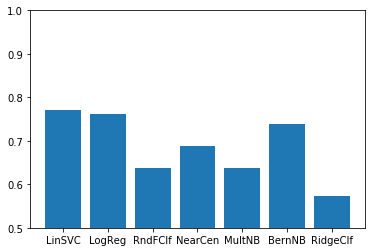

In [105]:
count = range(len(final_scores))
plt.ylim(0.5, 1)
plt.bar(count, np.array(list(final_scores.values()))-0.5, bottom=0.5)
plt.xticks(count, list(final_scores.keys()))
plt.show()